# Why Analyze Hotel Cancellation Data?
1. Impact on Demand Management Decisions: Cancellations hinder accurate demand forecasting, making them a crucial element in hotel revenue management.
2. Common Strategies in Hotels: Hotels often employ restrictive cancellation policies and overbooking strategies. Such strategies can decrease both the number of reservations and overall revenue.
3. Reducing Uncertainty: Analyzing cancellations can reduce uncertainties and increase confidence in demand management decisions.

# Factors Affecting Hotel Cancellation
1. Internal Hotel Factors: Variety of facilities, service quality, brand recognition, location, and star ratings.
2. Customer Factors: Age, customer type, market segmentation, distribution channels, gender, nationality.
3. Booking Factors: Price, length of stay, booking time, party size, time of year, weekday/weekend, deposit.
4. External Factors: Third-party recommendations (booking path), competitors' prices, events, weather, macroeconomic performance.

# Outcomes of This Analysis: Demand Management Decisions
1. Model Development: Developed a model using collected data, achieving a Mean Squared Error (MSE) of 0.26 in predicting booking cancellations.
2. Enhancing Net Demand Prediction: Assists hotels in improving net demand forecasts, refining cancellation policies, and defining overbooking strategies.
3. Confident Pricing and Inventory Allocation: Contributes to enabling hotels to use more assertive pricing and inventory allocation strategies.
4. Need for Customized Models: Highlights the need for tailored models for each hotel, as cancellation patterns vary across different hotel characteristics.

In [1]:
import pandas as pd
df = pd.read_csv('hotel_bookings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

1. Data Cleansing

In [2]:
null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
hotel,0,0.000000
is_canceled,0,0.000000
lead_time,0,0.000000
arrival_date_year,0,0.000000
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
arrival_date_day_of_month,0,0.000000
stays_in_weekend_nights,0,0.000000
stays_in_week_nights,0,0.000000
adults,0,0.000000


2. handling NA
- children, country, agent: fill with 0
- company: delete column
- zero adult, zero children, zero babies: delete row

In [3]:
df.drop('company', axis = 1, inplace = True)
df.fillna(0, inplace = True)

null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})

In [4]:
df = df[(df['adults'] + df['children'] + df['babies']) != 0]
len(df)

119210

3. Cancellation Prediction (logistic regression)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


In [6]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [7]:
df['is_canceled'].value_counts()

is_canceled
0    75011
1    44199
Name: count, dtype: int64

In [8]:
# Calculating the value counts of 'previous_cancellations'
cancellations_counts = df['previous_cancellations'].value_counts()

# Converting the Series to a DataFrame
count1 = pd.DataFrame(cancellations_counts).reset_index()
count1.columns = ['previous_cancellations', 'count']
sorted_count1 = count1.sort_values(by='previous_cancellations', ascending=True)
sorted_count1
# normally ppl dont cancel their booking, but if they do, they will cancel it
# so the previous cancellation will be a good indicator for the cancellation
# so if hotels know that the customer has a history of cancelling their booking, they can take some action to prevent it


,previous_cancellations,count
0,0,112731
1,1,6048
2,2,114
3,3,65
6,4,31
11,5,19
9,6,22
5,11,35
13,13,12
12,14,14


In [10]:
df['total_night'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [11]:
df['customer_type'].value_counts()

customer_type
Transient          89476
Transient-Party    25088
Contract            4072
Group                574
Name: count, dtype: int64

In [12]:
# select columns for model
selected_columns = ['is_canceled', 'lead_time', 'total_night', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

df_selected = df[selected_columns]

In [13]:
# transform categorical columns
df['is_canceled'] = df['is_canceled'].astype(int)
df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

In [14]:
categorical_vars = df_selected.select_dtypes(include=['object']).columns
categorical_vars

Index(['customer_type'], dtype='object')

In [15]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
df_encoded = pd.DataFrame(onehotencoder.fit_transform(df_selected[categorical_vars]).toarray())

In [16]:
df_encoded

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
119205,0.0,0.0,1.0,0.0
119206,0.0,0.0,1.0,0.0
119207,0.0,0.0,1.0,0.0
119208,0.0,0.0,1.0,0.0


In [17]:
df_encoded.columns = onehotencoder.get_feature_names_out(categorical_vars)

df_selected = df_selected.drop(categorical_vars, axis=1)
df_selected = pd.concat([df_selected, df_encoded], axis=1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

In [19]:
df_selected.fillna(0, inplace=True)

In [20]:
X = df_selected.drop('is_canceled', axis=1)
y = df_selected['is_canceled']

In [21]:
# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [34]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mse

0.2576848982326828

In [35]:
model.coef_

array([[ 5.29803400e-01,  2.79525355e-03,  6.81610714e-02,
         3.10963355e-02,  1.64843229e-02, -1.70669405e-01,
         2.52668484e+00, -9.17894528e-01, -4.04826868e-01,
         2.71219947e-03, -1.78016045e-02,  3.16446590e-01,
        -4.06949874e+00, -5.89596671e-01,  5.94188755e-01,
         1.78818383e-01,  1.85714116e+00,  1.43982262e+00]])

It means if customer type is transient, then it is more likely to cancel the booking. especially, the posibility of transient customer will cancel the booking is 19.7% is higher than other customer type.

In [38]:
report = classification_report(y_test, y_pred)
report

'              precision    recall  f1-score   support\n\n         0.0       0.75      0.88      0.81     14999\n         1.0       0.71      0.51      0.60      8879\n\n    accuracy                           0.74     23878\n   macro avg       0.73      0.70      0.70     23878\nweighted avg       0.74      0.74      0.73     23878\n'

In [39]:
import pandas as pd
import numpy as np

coefficients = model.coef_[0]
coefficients_df = pd.DataFrame({'Coefficient': coefficients})

coefficients_df['Odds Ratio'] = np.exp(coefficients_df['Coefficient'])

coefficients_df.index = X_train.columns

coefficients_df = coefficients_df.sort_values(by='Odds Ratio', ascending=False)

print(coefficients_df.to_string())


                                Coefficient  Odds Ratio
previous_cancellations             2.526685   12.511958
customer_type_Transient            1.857141    6.405399
customer_type_Transient-Party      1.439823    4.219947
customer_type_Contract             0.594189    1.811561
lead_time                          0.529803    1.698598
adr                                0.316447    1.372243
customer_type_Group                0.178818    1.195804
adults                             0.068161    1.070538
children                           0.031096    1.031585
babies                             0.016484    1.016621
total_night                        0.002795    1.002799
agent                              0.002712    1.002716
days_in_waiting_list              -0.017802    0.982356
is_repeated_guest                 -0.170669    0.843100
booking_changes                   -0.404827    0.667092
total_of_special_requests         -0.589597    0.554551
previous_bookings_not_canceled    -0.917895    0

C:\Users\sooye\AppData\Local\Temp\ipykernel_18624\4002547397.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Odds Ratio", y=coefficients_df.index, data=coefficients_df, palette=colors)  # coefficients_df 사용


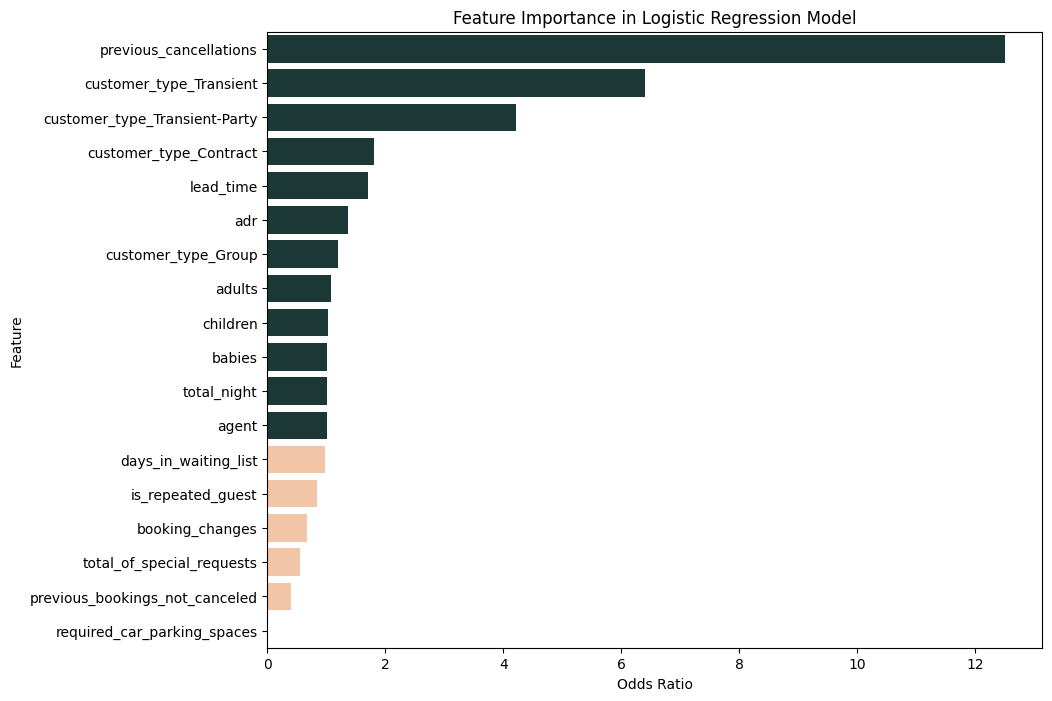

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#173d3a' if x > 1 else '#ffc39a' for x in coefficients_df['Odds Ratio']]  # coefficients_df 사용

plt.figure(figsize=(10, 8))
sns.barplot(x="Odds Ratio", y=coefficients_df.index, data=coefficients_df, palette=colors)  # coefficients_df 사용
plt.title("Feature Importance in Logistic Regression Model")
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.show()


# Odds Ratio
They provide a more intuitive measure of the effect size. An Odds Ratio greater than 1 indicates an increase in odds of the outcome, while less than 1 indicates a decrease.
They are easier to interpret compared to raw coefficients, especially in terms of understanding the relative change in odds for each unit increase in the predictor.

# Summary of Result
Features like 'previous_cancellations', 'deposit_type_Non Refund', and 'customer_type_Transient' significantly increase the odds of cancellation, with 'previous_cancellations' having the most substantial effect.
On the other hand, features like 'required_car_parking_spaces', 'is_repeated_guest', and 'deposit_type_Refundable' are associated with a decrease in the odds of cancellation.
'required_car_parking_spaces' shows a strong negative relationship, meaning its presence greatly reduces the odds of cancellation.
This analysis helps in understanding which factors are most influential in predicting hotel booking cancellations.